In [6]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 120

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, classification_report


# make parent kaggle folder importable
import sys
import os
sys.path.append(os.path.abspath("../"))
import importlib
import utils as u
import graphs as g
import processing as p
import extraction as e
import selection as s
import model as m

# Data

In [7]:
train_data = pd.read_csv('input/train.csv')
train_data = train_data.fillna('')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [8]:
test_data = pd.read_csv('input/test.csv')
test_data = test_data.fillna('')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      int64
question1    object
question2    object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


# Sample extraction

In [ ]:
import itertools

d = train_data[train_data.qid1==8461]
print(q.shape)

ids = list(itertools.combinations(d.qid2, 2))[0]
print(ids)

m = pd.concat([train_data, q], axis=0, ignore_index=True, verify_integrity=True, join='inner')
u.log('t', train_data.shape)
u.log('m', m.shape)

# u.log('cs', len(cs))

# train_data[['qid1']].groupby(['qid1']).size()

# Feature extraction

In [31]:
importlib.reload(p)

data = train_data.question1.append(train_data.question2)
text = data.append(test_data.question1).append(test_data.question2).values

question_we = p.word_encoder(text, title='corpus', stop_words=[], max_features=4000)
question_features = question_we.get_feature_names()

# u.log('features', question_features)

corpus: 4000 


In [32]:
importlib.reload(e)

x_q1 = e.extract(train_data, 'question1', question_we)
x_q2 = e.extract(train_data, 'question2', question_we)

# x_q1_test = e.extract(test_data, 'question1', question_we)
# x_q2_test = e.extract(test_data, 'question2', question_we)

E question1: (404290, 4000) 
E question2: (404290, 4000) 


In [ ]:
train_data['words1'] = train_data.question1.map(lambda q: len(q.split()))
train_data['words2'] = train_data.question2.map(lambda q: len(q.split()))

In [ ]:
g.plot_correlation_map(train_data)

# Feature selection

In [33]:
labels = ['0', '1']

y = train_data.is_duplicate
# print(y.value_counts())
Y = p.onehot(y)

Y: (404290, 2) 


In [ ]:
importlib.reload(s)

pf1 = s.percentile_filter(x_q1, y, percentile=25)
pf2 = s.percentile_filter(x_q2, y, percentile=25)

# X0 = p.scale(train_data[['words1', 'words2']])
x1 = s.select(x_q1, pf1, question_features)
x2 = s.select(x_q2, pf2, question_features)

x = pd.DataFrame(index=train_data.index)
x = pd.merge(x, x1, left_index=True, right_index=True)
x = pd.merge(x, x2, left_index=True, right_index=True)
X = x.values

# x1_test, selector = s.select(x_q1_test, y, question_features, 'question1')
# x2_test, selector = s.select(x_q2_test, y, question_features, 'question2')

# x_test = pd.DataFrame(index=test_data.index)
# x_test = pd.merge(x, x1_test, left_index=True, right_index=True)
# x_test = pd.merge(x_test, x2_test, left_index=True, right_index=True)
# X_test = x_test.values

u.log('X train', X.shape)
# u.log('X test', X_test.shape)

S: (404290, 1000) 
S: (404290, 1000) 


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

u.log('X train', X_train.shape)
u.log('y train', y_train.shape)
Y_train = p.onehot(y_train, title='Y train')

u.log('X val', X_val.shape)
u.log('y val', y_val.shape)
Y_val = p.onehot(y_val, title='Y val')

X train: (270874, 2000) 
y train: (270874,) 
Y train: (270874, 2) 
X val: (133416, 2000) 
y val: (133416,) 
Y val: (133416, 2) 


# Model

## Keras

In [30]:
importlib.reload(m)
from keras import optimizers as o
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model = m.keras_single_classification(X.shape[1])
model.compile(loss='binary_crossentropy', optimizer=o.RMSprop(lr=1e-4), metrics=['accuracy'], class_weight=cw)
history = model.fit(X_train, y_train, epochs=10, batch_size=10000)

result = model.evaluate(X_val, y_val, verbose=1)
print('')
u.log(model.metrics_names, result)

# plt.figure(figsize=(12,8))
# g.plot_accuracy(history)
# g.plot_loss(history)

/Users/icostan/Work/kaggle/ENV/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/10
270874/270874 [==============================] - 87s - loss: 0.6242 - acc: 0.6901     

## Scikit

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier

# clf = RandomForestClassifier(loss='log', class_weight='balanced', n_iter=100, verbose=0)
# clf = GradientBoostingClassifier(n_estimators=10, random_state=6, verbose=1)
# clf = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5, verbose=1)
# clf = KNeighborsClassifier()
# clf = SGDClassifier(verbose=1)
# clf = MultinomialNB()

clf.fit(X_train, y_train)
u.log('Score', clf.score(X_val, y_val))

# Cross validation

Logloss: 0.540072276527 
R:              precision    recall  f1-score   support

          0       0.74      0.89      0.80     84165
          1       0.70      0.46      0.55     49251

avg / total       0.72      0.73      0.71    133416
 
Confusion matrix, without normalization
[[74616  9549]
 [26814 22437]]


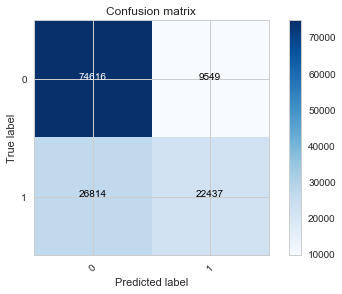

In [28]:
# y_val_prob = clf.predict_proba(X_val)
# y_val_prob = model.predict(X_val)
y_val_pred = (y_val_prob > 0.5).astype('int32')

u.log('Logloss', log_loss(y_val, y_val_prob))
u.log('R', classification_report(y_val, y_val_pred, target_names=labels))

cm = confusion_matrix(y_val, y_val_pred)
g.plot_confusion_matrix(cm, labels)

# Prediction

In [ ]:
from keras.models import load_model

keras = load_model('keras.h5')
print(keras.summary())

# YY = clf.predict_proba(X_test)
YY = keras.predict(X_test)

# print(YY.shape)
# print(YY[:10])

# Submission

In [ ]:
import time

sample = pd.read_csv('input/sample_submission.csv')
print(sample.shape)

submission = pd.DataFrame(columns=['test_id', 'is_duplicate'])
submission.test_id = sample.test_id
submission.is_duplicate = YY[:, 1]
submission.info()

filename = 'submission-' + time.strftime("%Y%m%d%H%M", time.gmtime()) + '.csv'
submission.to_csv(filename, index=False)